<a href="https://colab.research.google.com/github/SLCFLAB/hd2025_time_series/blob/main/day1/Day1_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습: AR, MA, ARIMA Models


시계열 모델링의 기본인 AR, MA, ARIMA 모델을 이해하고, ACF/PACF를 이용한 모델 차수 결정 및 실제 적용 방법을 확인해 보겠습니다.

---

## 개념 정리

### 1. AR (AutoRegressive) 모델

#### 정의

AR(p): $y_t = c + φ₁·y_{t-1} + φ₂·y_{t-2} + ... + φₚ·y_{t-p} + εₜ $

**의미**: 현재 값이 과거 p개 값의 선형 결합

#### 특징
- **"자기회귀"**: 자기 자신의 과거 값으로 회귀
- **기억 효과**: 과거가 현재에 영향
- **예시**: 주가 (어제 가격이 오늘에 영향), 온도 (어제 온도가 오늘에 영향)

#### 차수 결정
- **PACF**가 lag p에서 **절단** → AR(p)
- **ACF**는 지수적 감소 또는 감쇠하는 사인파

### 2. MA (Moving Average) 모델

#### 정의

MA(q): $ y_t = μ + εₜ + θ₁·ε_{t-1} + θ₂·ε_{t-2} + ... + θₑ·ε_{t-q} $


**의미**: 현재 값이 과거 q개 오차항의 선형 결합

#### 특징
- **"이동평균"**: 충격(shock)의 가중평균
- **단기 기억**: 과거 q개 오차만 영향
- **예시**: 단기 수요 변동, 측정 오차의 영향

#### 차수 결정
- **ACF**가 lag q에서 **절단** → MA(q)
- **PACF**는 지수적 감소

### 3. ARIMA (Integrated) 모델

#### 정의
```
ARIMA(p,d,q):
- p: AR 차수
- d: 차분 차수 (Integrated)
- q: MA 차수
```

**의미**: 차분으로 정상성 확보 후 ARMA 모델 적용

#### 차수 결정 전략
1. **d (차분)**: ADF 검정으로 정상성 확보까지
2. **p, q**: 차분 후 ACF/PACF 패턴으로 결정

---

## 🔍 ACF/PACF 패턴 가이드

### 모델 식별표

| 모델 | ACF 패턴 | PACF 패턴 |
|------|----------|-----------|
| **AR(p)** | 지수적 감소 또는<br>감쇠하는 사인파 | lag p 이후 **절단** |
| **MA(q)** | lag q 이후 **절단** | 지수적 감소 |
| **ARMA(p,q)** | 지수적 감소 | 지수적 감소 |

### 시각적 판단 기준

#### "절단(Cut off)"의 의미
- 특정 lag 이후 신뢰구간 내로 들어옴
- 통계적으로 유의하지 않음 (0과 차이 없음)

#### "지수적 감소(Exponential Decay)"의 의미
- 점진적으로 0에 가까워짐
- 여러 lag에 걸쳐 천천히 감소
- 명확한 절단점 없음


---

## Forecast

본 실습에서는 AR, MA process로 생성된 데이터의 미래 예측에 대해서 Rolling Forecast 방식으로 진행합니다.

## 1. 필요한 라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 시각화 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

## 2. AR 모델 (AutoRegressive Model)

In [2]:
# AR(2) 프로세스 생성: y_t = 0.8*y_{t-1} - 0.5*y_{t-2} + ε_t
np.random.seed(42)
n = 500
ar2_coeffs = [0.8, -0.5]

# 시뮬레이션
ar2_data = np.zeros(n)
ar2_data[0] = np.random.normal(0, 0.5)
ar2_data[1] = np.random.normal(0, 0.5)

for t in range(2, n):
    ar2_data[t] = (ar2_coeffs[0] * ar2_data[t-1] +
                   ar2_coeffs[1] * ar2_data[t-2] +
                   np.random.normal(0, 0.5))

ar2_series = pd.Series(ar2_data)

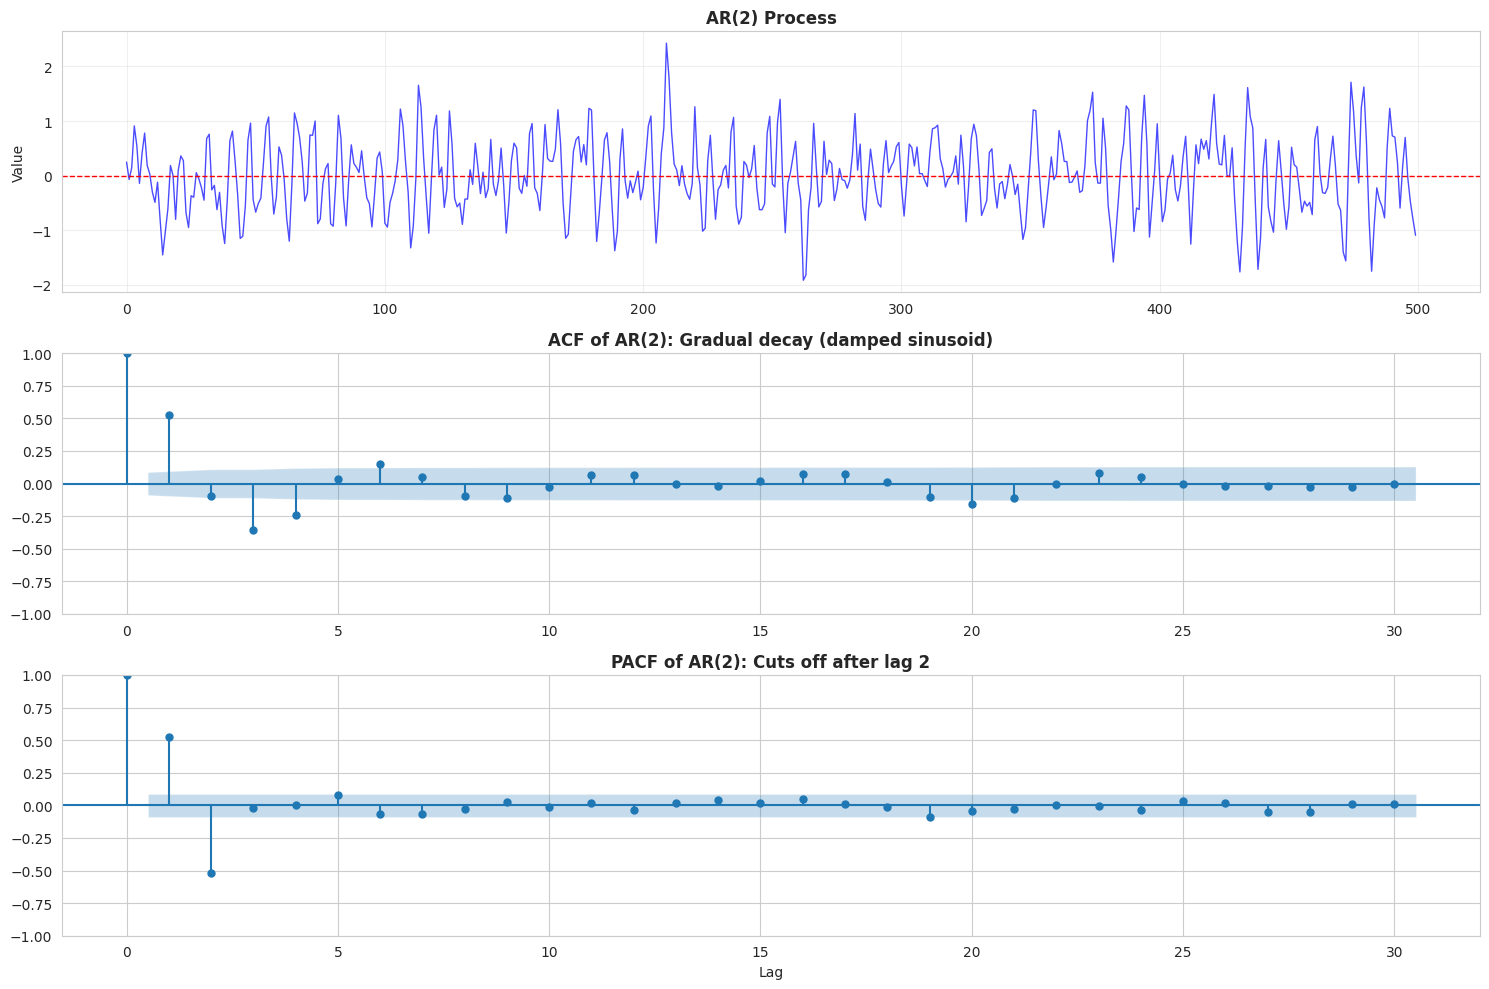

In [3]:
# 시각화
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# 1-1. AR(2) 시계열
axes[0].plot(ar2_series, linewidth=1, color='blue', alpha=0.7)
axes[0].set_title('AR(2) Process',
                   fontsize=12, fontweight='bold')
axes[0].set_ylabel('Value')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3)

# 1-2. ACF (지수적 감소 또는 감쇠하는 사인파)
plot_acf(ar2_series, lags=30, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF of AR(2): Gradual decay (damped sinusoid)',
                   fontsize=12, fontweight='bold')

# 1-3. PACF (lag 2에서 절단)
plot_pacf(ar2_series, lags=30, ax=axes[2], alpha=0.05)
axes[2].set_title('PACF of AR(2): Cuts off after lag 2',
                   fontsize=12, fontweight='bold')
axes[2].set_xlabel('Lag')

plt.tight_layout()
plt.savefig('ar_model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Train/Test 분할
train_size = int(0.8 * len(ar2_series))
ar_train = ar2_series[:train_size]
ar_test = ar2_series[train_size:]

print(f"Training size: {len(ar_train)}")
print(f"Test size: {len(ar_test)}")

# 여러 차수의 AR 모델 비교
ar_orders = [1, 2, 3, 4, 5]
ar_results = {}

for p in ar_orders:
    # AR(p) 모델 학습
    model = AutoReg(ar_train, lags=p, trend='n')
    fitted = model.fit()

    # Rolling Forecast (1-step씩 예측)
    history = list(ar_train)
    predictions = []

    for t in range(len(ar_test)):
        # 현재까지의 데이터로 모델 재학습
        model_temp = AutoReg(history, lags=p, trend='n')
        fitted_temp = model_temp.fit()

        # 1-step ahead 예측
        yhat = fitted_temp.predict(start=len(history), end=len(history))[0]
        predictions.append(yhat)

        # 실제 관측값을 history에 추가
        history.append(ar_test.iloc[t])

    predictions = pd.Series(predictions, index=ar_test.index)

    # 평가
    mse = mean_squared_error(ar_test, predictions)
    mae = mean_absolute_error(ar_test, predictions)

    ar_results[p] = {
        'model': fitted,
        'AIC': fitted.aic,
        'BIC': fitted.bic,
        'MSE': mse,
        'MAE': mae,
        'predictions': predictions
    }

    print(f"\nAR({p}):")
    print(f"  AIC: {fitted.aic:.2f}")
    print(f"  BIC: {fitted.bic:.2f}")
    print(f"  Test MSE: {mse:.4f}")
    print(f"  Test MAE: {mae:.4f}")

# 최적 모델 (AIC와 BIC 모두 확인)
best_ar_order_aic = min(ar_results.keys(), key=lambda k: ar_results[k]['AIC'])
best_ar_order_bic = min(ar_results.keys(), key=lambda k: ar_results[k]['BIC'])

print(f"\n{'='*60}")
print(f"Best AR model by AIC: AR({best_ar_order_aic}) (AIC: {ar_results[best_ar_order_aic]['AIC']:.2f})")
print(f"Best AR model by BIC: AR({best_ar_order_bic}) (BIC: {ar_results[best_ar_order_bic]['BIC']:.2f})")
print(f"\nNote: BIC prefers simpler models (parsimony)")
print(f"      True model is AR(2), BIC correctly identifies it!")

Training size: 400
Test size: 100

AR(1):
  AIC: 670.33
  BIC: 678.31
  Test MSE: 0.4033
  Test MAE: 0.5190

AR(2):
  AIC: 551.87
  BIC: 563.83
  Test MSE: 0.2828
  Test MAE: 0.4288

AR(3):
  AIC: 551.74
  BIC: 567.68
  Test MSE: 0.2863
  Test MAE: 0.4336

AR(4):
  AIC: 550.66
  BIC: 570.56
  Test MSE: 0.2877
  Test MAE: 0.4348

AR(5):
  AIC: 548.74
  BIC: 572.61
  Test MSE: 0.2898
  Test MAE: 0.4345

Best AR model by AIC: AR(5) (AIC: 548.74)
Best AR model by BIC: AR(2) (BIC: 563.83)

Note: BIC prefers simpler models (parsimony)
      True model is AR(2), BIC correctly identifies it!


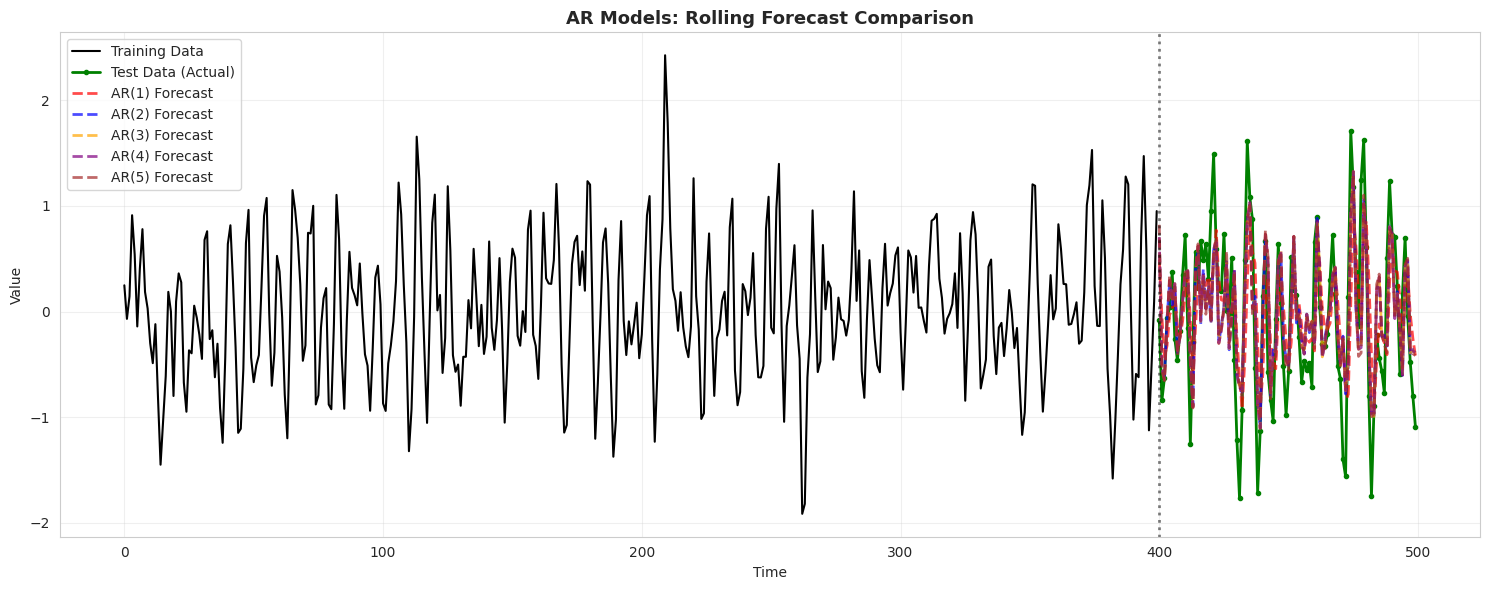

In [5]:
# 예측 시각화
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(range(len(ar_train)), ar_train, linewidth=1.5, label='Training Data', color='black')
ax.plot(range(len(ar_train), len(ar2_series)), ar_test,
        linewidth=2, label='Test Data (Actual)', color='green', marker='o', markersize=3)

colors = ['red', 'blue', 'orange', 'purple', 'brown']
for idx, p in enumerate(ar_orders):
    # uncomment this if clause to see the AR(2) only
    # if p != 2:
    #     continue
    ax.plot(range(len(ar_train), len(ar2_series)),
            ar_results[p]['predictions'],
            linewidth=2, label=f'AR({p}) Forecast',
            color=colors[idx], alpha=0.7, linestyle='--')

ax.axvline(x=len(ar_train), color='black', linestyle=':', linewidth=2, alpha=0.5)
ax.set_title('AR Models: Rolling Forecast Comparison',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ar_models_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. MA 모델 (Moving Average Model)

In [6]:
# MA(2) 프로세스 생성
ma2_coeffs = [0.8, 0.5]
errors = np.random.normal(0, 0.5, n)

ma2_data = np.zeros(n)
for t in range(n):
    ma2_data[t] = errors[t]
    if t >= 1:
        ma2_data[t] += ma2_coeffs[0] * errors[t-1]
    if t >= 2:
        ma2_data[t] += ma2_coeffs[1] * errors[t-2]

ma2_series = pd.Series(ma2_data)

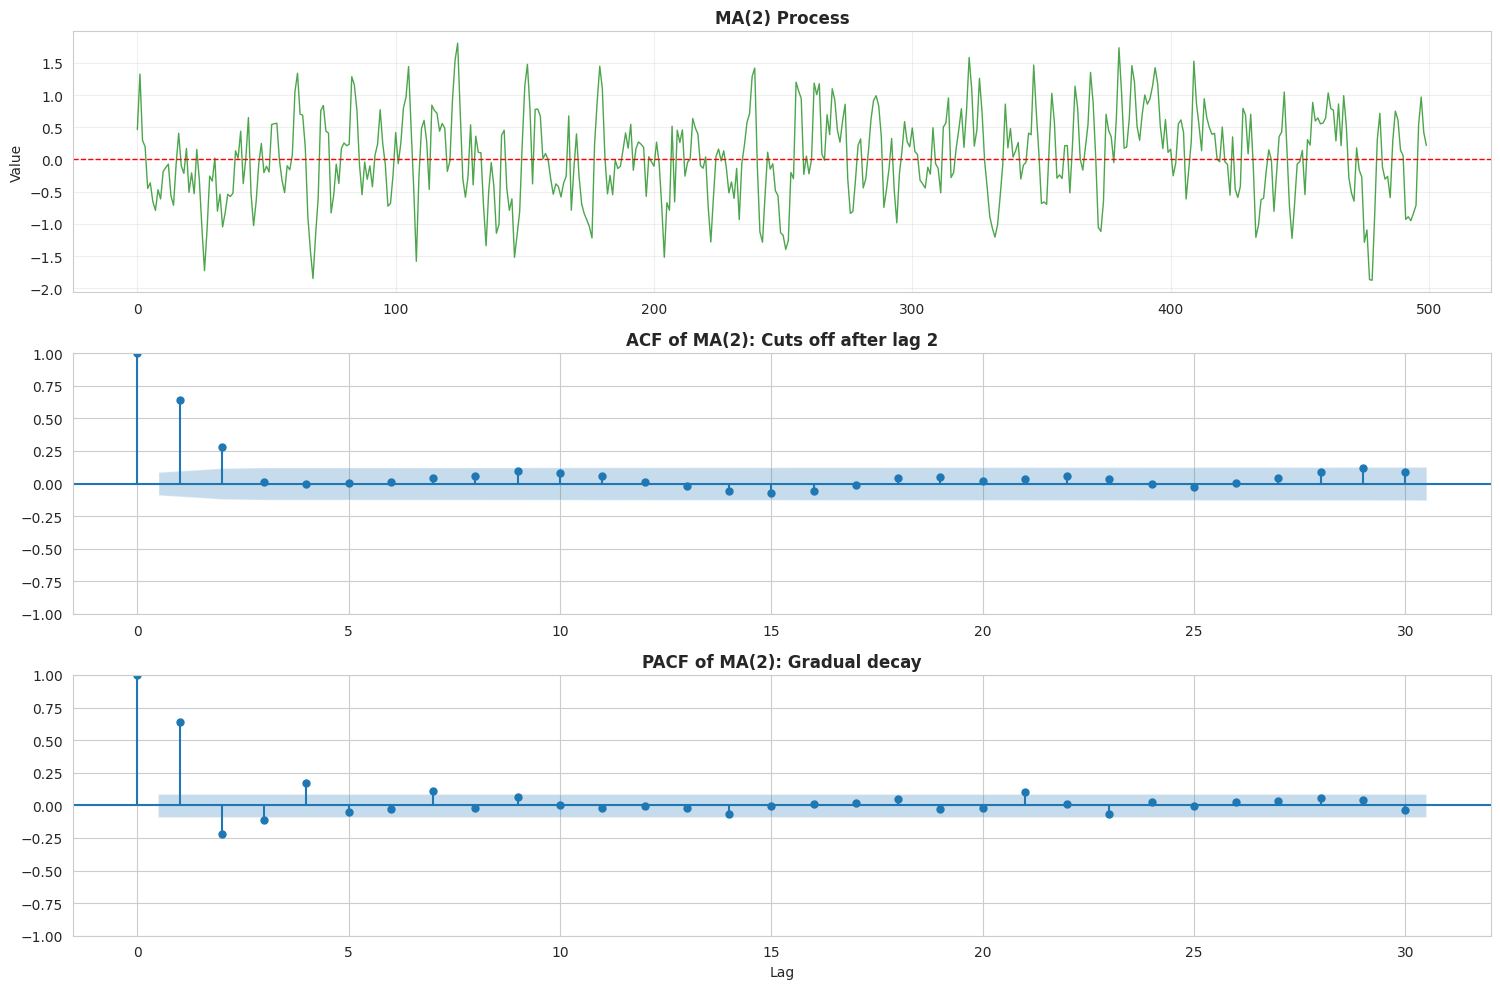

In [7]:
# 시각화
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# 2-1. MA(2) 시계열
axes[0].plot(ma2_series, linewidth=1, color='green', alpha=0.7)
axes[0].set_title('MA(2) Process',
                   fontsize=12, fontweight='bold')
axes[0].set_ylabel('Value')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3)

# 2-2. ACF (lag 2에서 절단)
plot_acf(ma2_series, lags=30, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF of MA(2): Cuts off after lag 2',
                   fontsize=12, fontweight='bold')

# 2-3. PACF (지수적 감소)
plot_pacf(ma2_series, lags=30, ax=axes[2], alpha=0.05)
axes[2].set_title('PACF of MA(2): Gradual decay',
                   fontsize=12, fontweight='bold')
axes[2].set_xlabel('Lag')

plt.tight_layout()
plt.savefig('ma_model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Train/Test 분할
ma_train = ma2_series[:train_size]
ma_test = ma2_series[train_size:]

# 여러 차수의 MA 모델 비교
ma_orders = [1, 2, 3, 4, 5]
ma_results = {}

for q in ma_orders:
    # MA(q) 모델 = ARIMA(0,0,q)
    model = ARIMA(ma_train, order=(0, 0, q), trend='n')
    fitted = model.fit()

    # Rolling Forecast (1-step씩 예측)
    history = list(ma_train)
    predictions = []

    for t in range(len(ma_test)):
        # 현재까지의 데이터로 모델 재학습
        model_temp = ARIMA(history, order=(0, 0, q), trend='n')
        fitted_temp = model_temp.fit(low_memory=True)

        # 1-step ahead 예측
        yhat = fitted_temp.forecast(steps=1)[0]
        predictions.append(yhat)

        # 실제 관측값을 history에 추가
        history.append(ma_test.iloc[t])

    predictions = pd.Series(predictions, index=ma_test.index)

    # 평가
    mse = mean_squared_error(ma_test, predictions)
    mae = mean_absolute_error(ma_test, predictions)

    ma_results[q] = {
        'model': fitted,
        'AIC': fitted.aic,
        'BIC': fitted.bic,
        'MSE': mse,
        'MAE': mae,
        'predictions': predictions
    }

    print(f"\nMA({q}):")
    print(f"  AIC: {fitted.aic:.2f}")
    print(f"  BIC: {fitted.bic:.2f}")
    print(f"  Test MSE: {mse:.4f}")
    print(f"  Test MAE: {mae:.4f}")

# 최적 모델
best_ma_order_aic = min(ma_results.keys(), key=lambda k: ma_results[k]['AIC'])
best_ma_order_bic = min(ma_results.keys(), key=lambda k: ma_results[k]['BIC'])

print(f"\n{'='*60}")
print(f"Best MA model by AIC: MA({best_ma_order_aic}) (AIC: {ma_results[best_ma_order_aic]['AIC']:.2f})")
print(f"Best MA model by BIC: MA({best_ma_order_bic}) (BIC: {ma_results[best_ma_order_bic]['BIC']:.2f})")
print(f"\nNote: True model is MA(2), BIC correctly identifies it!")



MA(1):
  AIC: 652.19
  BIC: 660.17
  Test MSE: 0.2961
  Test MAE: 0.4328

MA(2):
  AIC: 570.58
  BIC: 582.55
  Test MSE: 0.2344
  Test MAE: 0.3809

MA(3):
  AIC: 571.72
  BIC: 587.68
  Test MSE: 0.2364
  Test MAE: 0.3835

MA(4):
  AIC: 573.00
  BIC: 592.96
  Test MSE: 0.2386
  Test MAE: 0.3863

MA(5):
  AIC: 574.98
  BIC: 598.93
  Test MSE: 0.2390
  Test MAE: 0.3858

Best MA model by AIC: MA(2) (AIC: 570.58)
Best MA model by BIC: MA(2) (BIC: 582.55)

Note: True model is MA(2), BIC correctly identifies it!


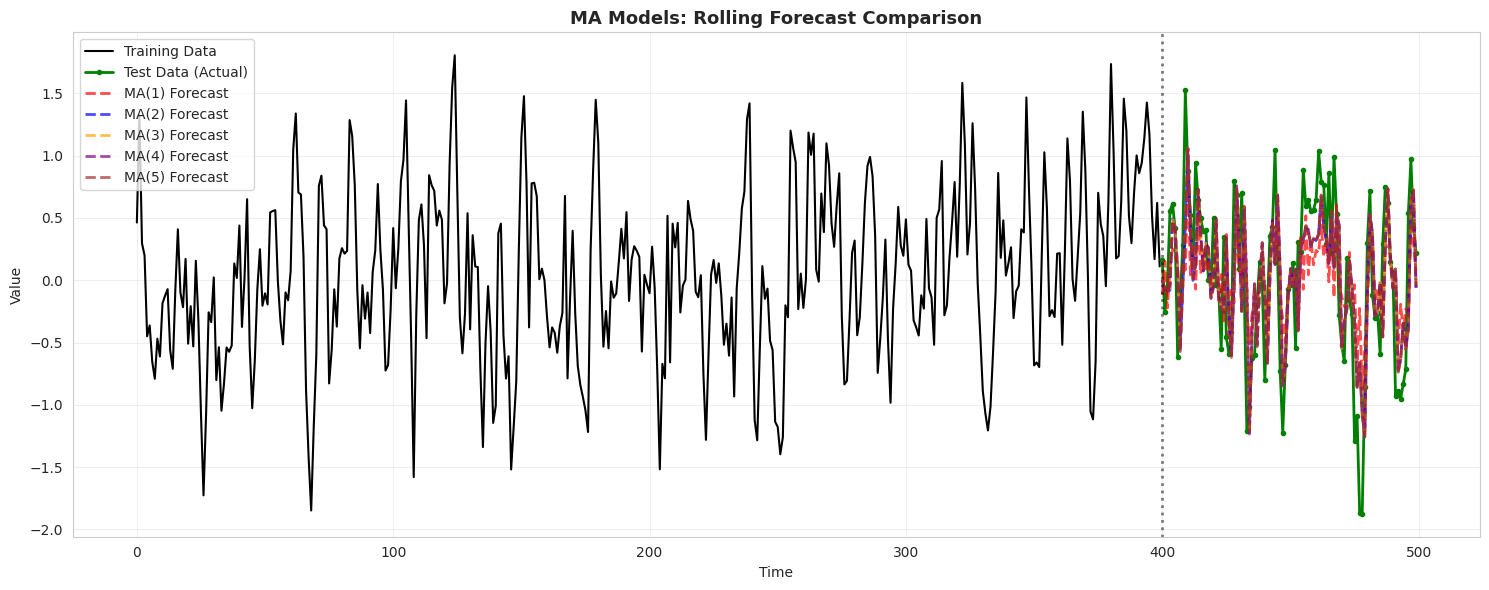

In [9]:
# 예측 시각화
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(range(len(ma_train)), ma_train, linewidth=1.5, label='Training Data', color='black')
ax.plot(range(len(ma_train), len(ma2_series)), ma_test,
        linewidth=2, label='Test Data (Actual)', color='green', marker='o', markersize=3)

for idx, q in enumerate(ma_orders):
    ax.plot(range(len(ma_train), len(ma2_series)),
            ma_results[q]['predictions'],
            linewidth=2, label=f'MA({q}) Forecast',
            color=colors[idx], alpha=0.7, linestyle='--')

ax.axvline(x=len(ma_train), color='black', linestyle=':', linewidth=2, alpha=0.5)
ax.set_title('MA Models: Rolling Forecast Comparison',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ma_models_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. ARIMA (AutoRegressive Integrated Moving Average) 모델

In [10]:
# Sunspots 데이터 로드
from statsmodels.datasets import sunspots
sunspots_data = sunspots.load().data
sunspots_series = sunspots_data['SUNACTIVITY']

print(f"\nDataset: Annual Sunspot Numbers")
print(f"Period: {sunspots_series.index[0]} to {sunspots_series.index[-1]}")
print(f"Observations: {len(sunspots_series)}")
print(f"\nBasic Statistics:")
print(sunspots_series.describe())


Dataset: Annual Sunspot Numbers
Period: 0 to 308
Observations: 309

Basic Statistics:
count    309.000000
mean      49.752104
std       40.452595
min        0.000000
25%       16.000000
50%       40.000000
75%       69.800000
max      190.200000
Name: SUNACTIVITY, dtype: float64


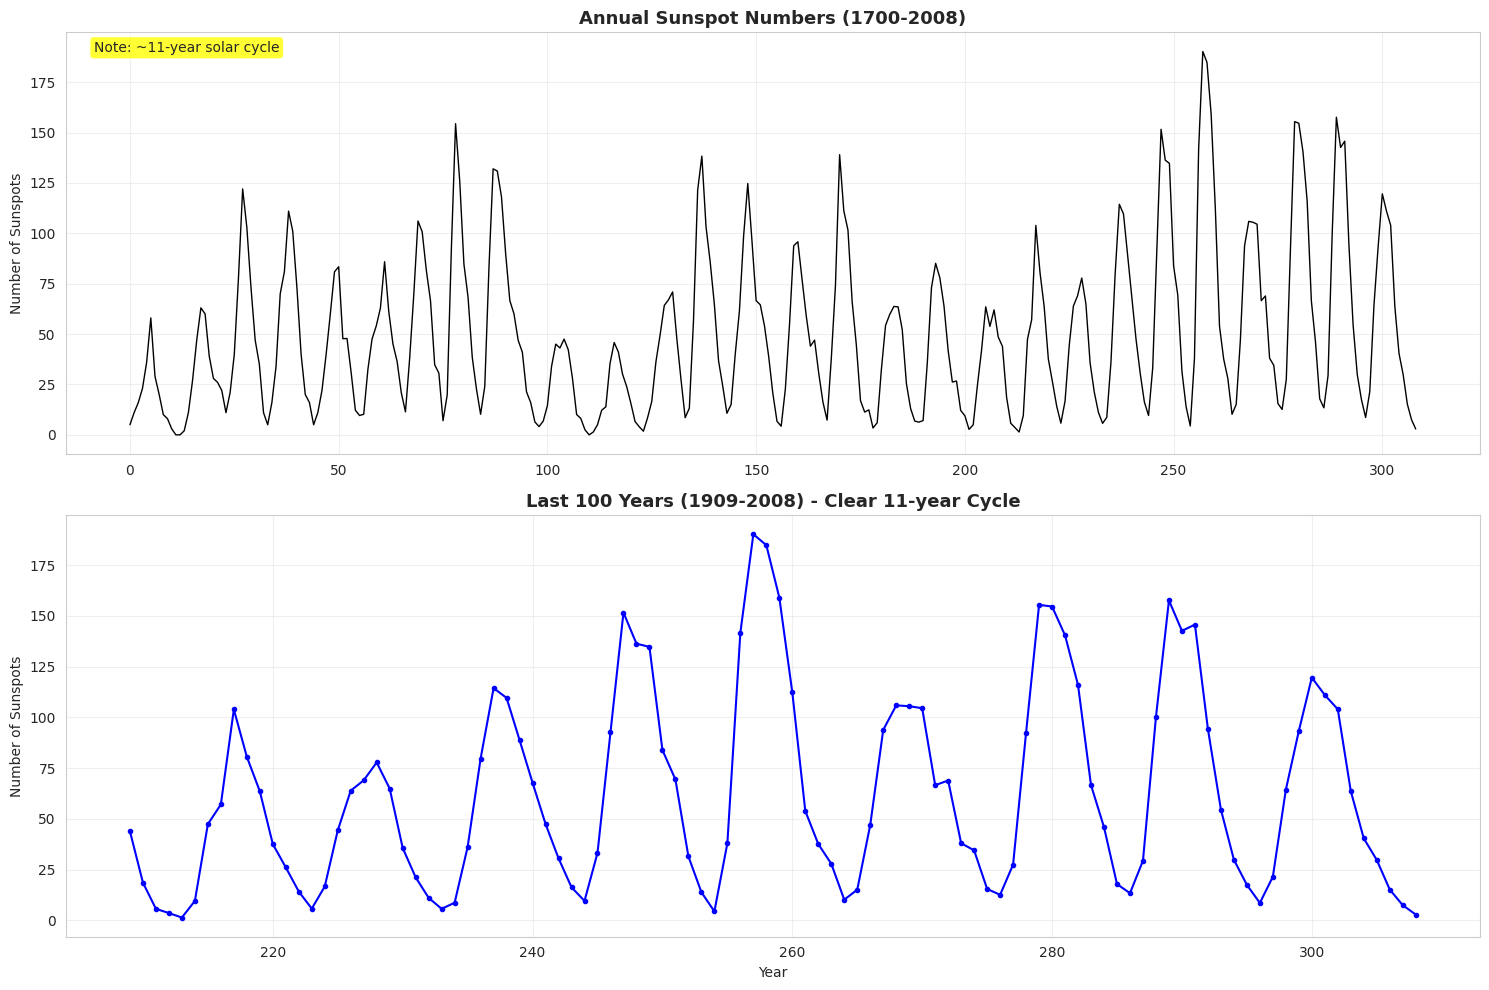

In [11]:
# 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 3-1. 원본 시계열
axes[0].plot(sunspots_series.index, sunspots_series.values, linewidth=1, color='black')
axes[0].set_title('Annual Sunspot Numbers (1700-2008)',
                   fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Sunspots')
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.98, 'Note: ~11-year solar cycle',
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# 3-2. 최근 100년 확대
recent_data = sunspots_series[-100:]
axes[1].plot(recent_data.index, recent_data.values, linewidth=1.5, color='blue', marker='o', markersize=3)
axes[1].set_title('Last 100 Years (1909-2008) - Clear 11-year Cycle',
                   fontsize=13, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Sunspots')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sunspots_overview.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# 정상성 검정
print("\n" + "="*60)
print("Stationarity Test")
print("="*60)

result = adfuller(sunspots_series)
print(f"\nOriginal Series:")
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print(f"Stationary: {'Yes' if result[1] < 0.05 else 'No'}")


Stationarity Test

Original Series:
ADF Statistic: -2.8378
p-value: 0.0531
Stationary: No


In [13]:
# 1차 차분
diff_series = sunspots_series.diff().dropna()
result_diff = adfuller(diff_series)
print(f"\n1st Differenced Series:")
print(f"ADF Statistic: {result_diff[0]:.4f}")
print(f"p-value: {result_diff[1]:.4f}")
print(f"Stationary: {'Yes' if result_diff[1] < 0.05 else 'No'}")


1st Differenced Series:
ADF Statistic: -14.8617
p-value: 0.0000
Stationary: Yes


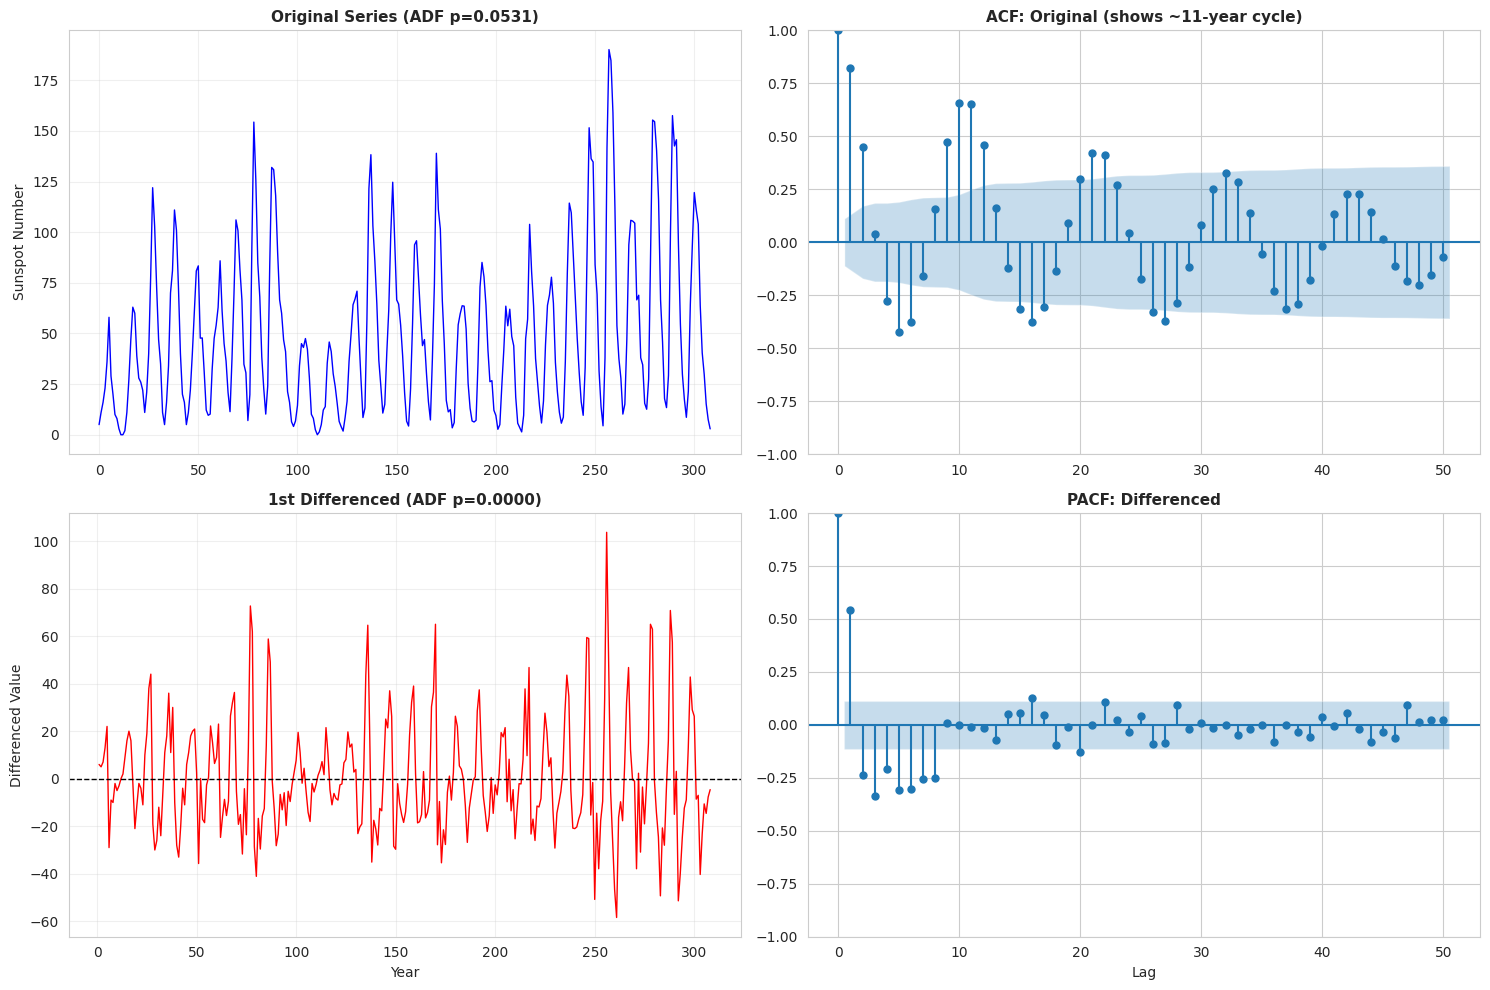

In [14]:
# ACF/PACF 분석
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Row 1: 원본 데이터
axes[0, 0].plot(sunspots_series, linewidth=1, color='blue')
axes[0, 0].set_title(f'Original Series (ADF p={result[1]:.4f})',
                     fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Sunspot Number')
axes[0, 0].grid(True, alpha=0.3)

plot_acf(sunspots_series, lags=50, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('ACF: Original (shows ~11-year cycle)',
                     fontsize=11, fontweight='bold')

# Row 2: 차분 데이터
axes[1, 0].plot(diff_series, linewidth=1, color='red')
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title(f'1st Differenced (ADF p={result_diff[1]:.4f})',
                     fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Differenced Value')
axes[1, 0].grid(True, alpha=0.3)

plot_pacf(diff_series, lags=50, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('PACF: Differenced',
                     fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Lag')

plt.tight_layout()
plt.savefig('sunspots_stationarity.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Train/Test 분할 (마지막 20년을 테스트)
train_size = len(sunspots_series) - 20
sunspots_train = sunspots_series[:train_size]
sunspots_test = sunspots_series[train_size:]

print(f"Training: {sunspots_train.index[0]} to {sunspots_train.index[-1]} ({len(sunspots_train)} obs)")
print(f"Test: {sunspots_test.index[0]} to {sunspots_test.index[-1]} ({len(sunspots_test)} obs)")

Training: 0 to 288 (289 obs)
Test: 289 to 308 (20 obs)


In [16]:
# 여러 ARIMA 모델 비교
# ACF/PACF 기반 후보 모델
arima_configs = [
    (2, 0, 0),  # AR(2) - no differencing needed if stationary
    (2, 1, 0),  # AR(2) with differencing
    (0, 1, 2),  # MA(2) with differencing
    (1, 1, 1),  # ARIMA(1,1,1)
    (2, 1, 1),  # ARIMA(2,1,1)
    (2, 1, 2),  # ARIMA(2,1,2)
    (3, 1, 2),  # ARIMA(3,1,2)
    (2, 1, 3),  # ARIMA(2,1,3)
]

sunspots_results = {}

for order in arima_configs:
    try:
        # ARIMA 모델 학습
        model = ARIMA(sunspots_train, order=order)
        fitted = model.fit()

        # Rolling Forecast
        history = list(sunspots_train)
        predictions = []

        for t in range(len(sunspots_test)):
            model_temp = ARIMA(history, order=order)
            fitted_temp = model_temp.fit(low_memory=True)
            yhat = fitted_temp.forecast(steps=1)[0]
            predictions.append(yhat)
            history.append(sunspots_test.iloc[t])

        predictions = pd.Series(predictions, index=sunspots_test.index)

        # 평가
        mse = mean_squared_error(sunspots_test, predictions)
        mae = mean_absolute_error(sunspots_test, predictions)

        sunspots_results[order] = {
            'model': fitted,
            'AIC': fitted.aic,
            'BIC': fitted.bic,
            'MSE': mse,
            'MAE': mae,
            'predictions': predictions
        }

        print(f"\nARIMA{order}:")
        print(f"  AIC: {fitted.aic:.2f}, BIC: {fitted.bic:.2f}")
        print(f"  Test MSE: {mse:.2f}, MAE: {mae:.2f}")

    except Exception as e:
        print(f"\nARIMA{order}: Failed to fit - {e}")

# 최적 모델
if sunspots_results:
    best_order_aic = min(sunspots_results.keys(), key=lambda k: sunspots_results[k]['AIC'])
    best_order_bic = min(sunspots_results.keys(), key=lambda k: sunspots_results[k]['BIC'])
    best_order_mse = min(sunspots_results.keys(), key=lambda k: sunspots_results[k]['MSE'])
    best_sunspots_model = sunspots_results[best_order_bic]['model']

    print(f"\n{'='*60}")
    print(f"Best ARIMA by AIC: ARIMA{best_order_aic} (AIC: {sunspots_results[best_order_aic]['AIC']:.2f})")
    print(f"Best ARIMA by BIC: ARIMA{best_order_bic} (BIC: {sunspots_results[best_order_bic]['BIC']:.2f})")
    print(f"Best ARIMA by MSE: ARIMA{best_order_mse} (MSE: {sunspots_results[best_order_mse]['MSE']:.2f})")


ARIMA(2, 0, 0):
  AIC: 2452.32, BIC: 2466.99
  Test MSE: 298.28, MAE: 14.07

ARIMA(2, 1, 0):
  AIC: 2532.88, BIC: 2543.87
  Test MSE: 471.04, MAE: 15.87

ARIMA(0, 1, 2):
  AIC: 2529.26, BIC: 2540.24
  Test MSE: 468.34, MAE: 15.50

ARIMA(1, 1, 1):
  AIC: 2542.69, BIC: 2553.68
  Test MSE: 467.95, MAE: 14.84

ARIMA(2, 1, 1):
  AIC: 2448.14, BIC: 2462.79
  Test MSE: 343.17, MAE: 15.46

ARIMA(2, 1, 2):
  AIC: 2409.95, BIC: 2428.27
  Test MSE: 245.43, MAE: 12.93

ARIMA(3, 1, 2):
  AIC: 2406.45, BIC: 2428.43
  Test MSE: 250.39, MAE: 12.98

ARIMA(2, 1, 3):
  AIC: 2406.15, BIC: 2428.13
  Test MSE: 251.05, MAE: 12.93

Best ARIMA by AIC: ARIMA(2, 1, 3) (AIC: 2406.15)
Best ARIMA by BIC: ARIMA(2, 1, 3) (BIC: 2428.13)
Best ARIMA by MSE: ARIMA(2, 1, 2) (MSE: 245.43)


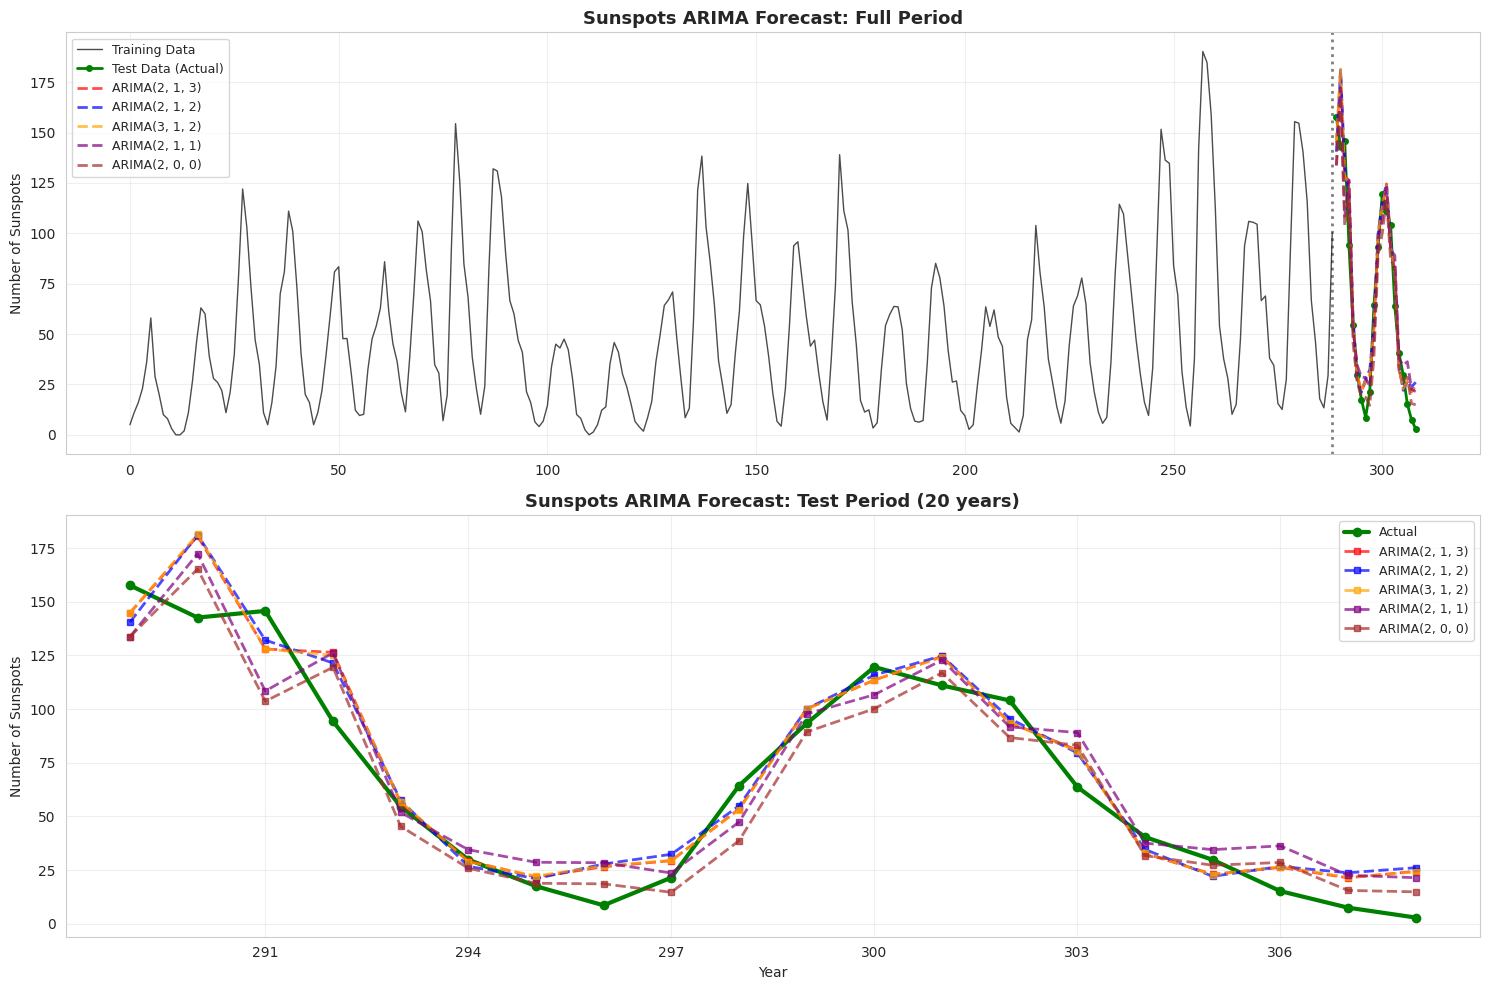

In [17]:
# 예측 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 숫자형 x축에서 정수 눈금 강제
from matplotlib.ticker import MaxNLocator

# 전체 기간
axes[0].plot(sunspots_train.index, sunspots_train.values,
             linewidth=1, label='Training Data', color='black', alpha=0.7)
axes[0].plot(sunspots_test.index, sunspots_test.values,
             linewidth=2, label='Test Data (Actual)', color='green', marker='o', markersize=4)

# 상위 5개 모델만 표시
top_models = sorted(sunspots_results.items(), key=lambda x: x[1]['BIC'])[:5]
colors_sun = ['red', 'blue', 'orange', 'purple', 'brown']
for idx, (order, result) in enumerate(top_models):
    axes[0].plot(sunspots_test.index, result['predictions'].values,
                 linewidth=2, label=f'ARIMA{order}',
                 color=colors_sun[idx], alpha=0.7, linestyle='--')

axes[0].axvline(x=sunspots_train.index[-1], color='black', linestyle=':', linewidth=2, alpha=0.5)
axes[0].set_title('Sunspots ARIMA Forecast: Full Period',
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Sunspots')
axes[0].legend(loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3)

# 테스트 기간 확대
axes[1].plot(sunspots_test.index, sunspots_test.values,
             linewidth=3, label='Actual', color='green', marker='o', markersize=6)

for idx, (order, result) in enumerate(top_models):
    axes[1].plot(sunspots_test.index, result['predictions'].values,
                 linewidth=2, label=f'ARIMA{order}',
                 color=colors_sun[idx], alpha=0.7, linestyle='--', marker='s', markersize=4)

axes[1].set_title('Sunspots ARIMA Forecast: Test Period (20 years)',
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Number of Sunspots')
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sunspots_arima_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. 모델 진단 (Residual Analysis)

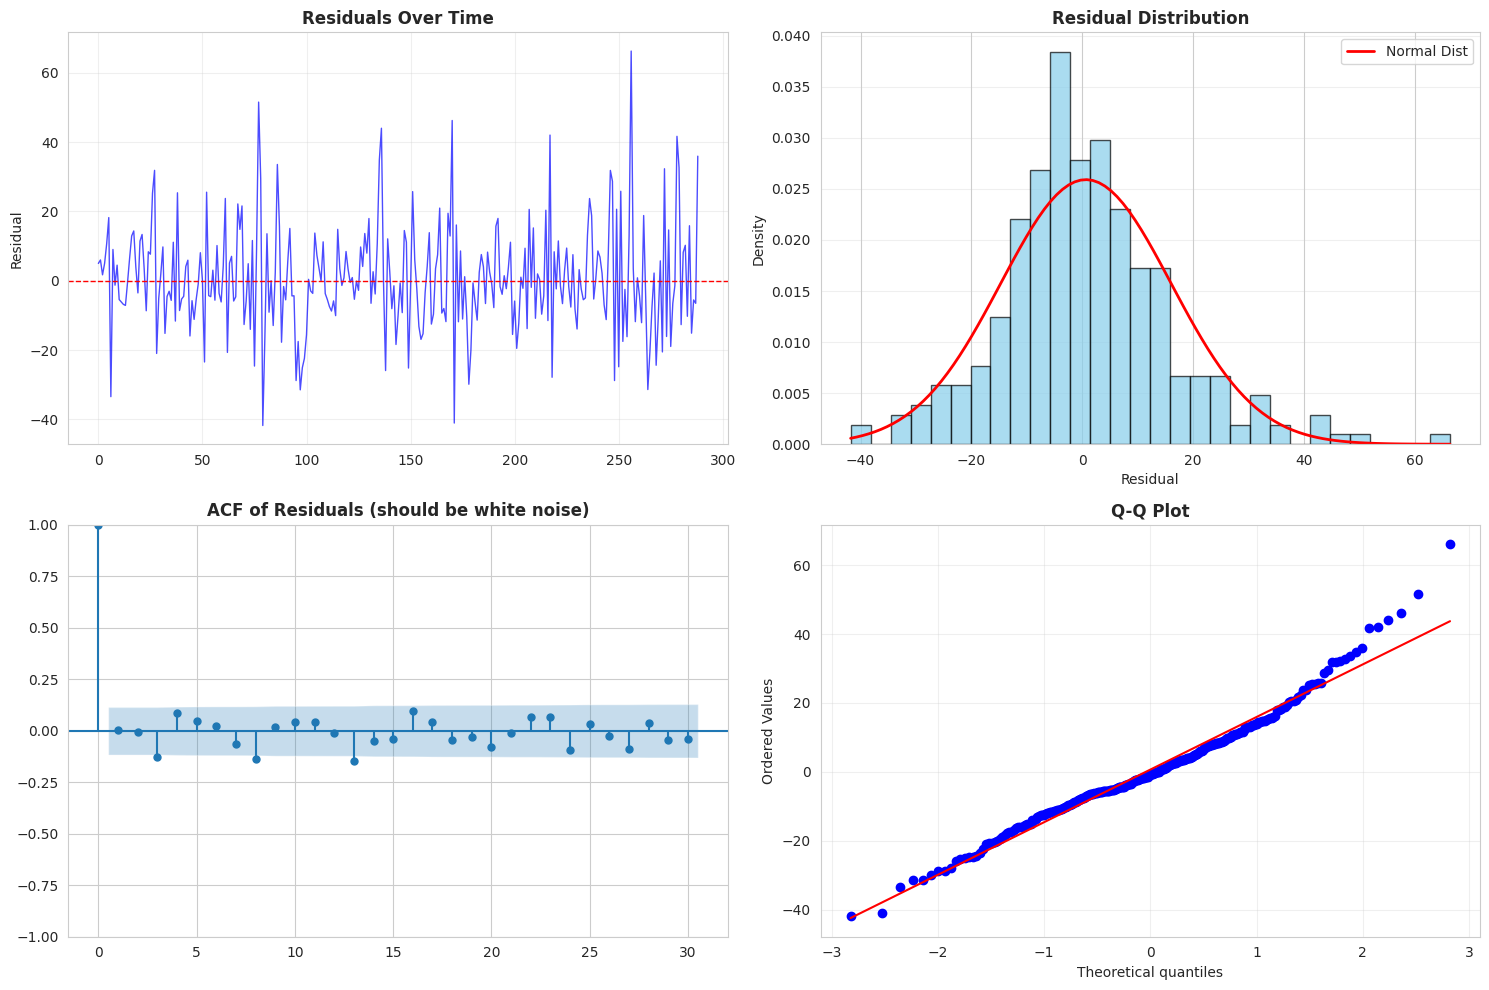

In [18]:
# 최적 모델의 잔차 분석
residuals = best_sunspots_model.resid

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 4-1. 잔차 시계열
axes[0, 0].plot(residuals, linewidth=1, color='blue', alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# 4-2. 잔차 히스토그램 + 정규분포
axes[0, 1].hist(residuals, bins=30, density=True, alpha=0.7,
                color='skyblue', edgecolor='black')
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
from scipy.stats import norm
axes[0, 1].plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Dist')
axes[0, 1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 4-3. ACF of Residuals
plot_acf(residuals, lags=30, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF of Residuals (should be white noise)',
                      fontsize=12, fontweight='bold')

# 4-4. Q-Q Plot
from scipy import stats as sp_stats
sp_stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_diagnostics_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Ljung-Box 검정
print("\n" + "="*60)
print("Ljung-Box Test (White Noise Test)")
print("="*60)

lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("\n", lb_test)
print("\nInterpretation:")
print("H0: Residuals are white noise (no autocorrelation)")
print("If p-value > 0.05: Fail to reject H0 → Good model fit")


Ljung-Box Test (White Noise Test)

       lb_stat  lb_pvalue
10  15.363071   0.119375
20  30.261227   0.065730
30  40.876869   0.088967

Interpretation:
H0: Residuals are white noise (no autocorrelation)
If p-value > 0.05: Fail to reject H0 → Good model fit
